# Analyzing NER Model Performance Over Time

In this notebook, we will analyze the performance of the best performing Named Entity Recognition (NER) model over time. The key steps involved in this analysis are as follows:

1. **Error Aggregation:** Aggregate the errors made by the NER model for each year.
2. **Visualization:** Create visualizations to illustrate the model's performance trends over time, highlighting any patterns or changes in accuracy.

By the end of this notebook, we will have a clear understanding of how the NER model's performance has evolved over different time periods, providing insights into its reliability and areas for improvement.

Let's get started!


## Import necessary libraries

In [1]:
# !python -m spacy download nl_core_news_sm

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import string
import re

from datasets import Dataset, load_metric
from transformers import DataCollatorForTokenClassification, pipeline, AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, TrainerCallback

import torch

import spacy
from spacy import displacy

import os
from datetime import datetime
import json

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import pickle
import math

C:\Users\niels\miniconda3\envs\BookReviewsThesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get the current notebook directory
current_dir = os.path.abspath('')

# Set the main directory (modify as needed to point to your main project directory)
main_dir = os.path.abspath(os.path.join(current_dir, '../'))

# Change the working directory to the main directory
os.chdir(main_dir)

# Verify that the working directory has been set correctly
print(f"Current working directory: {os.getcwd()}")

Current working directory: C:\Users\niels\PycharmProjects\BookReviewsThesis


In [4]:
# Import custom functions from the dataset preparation module
from scripts.loss_functions import DiceLoss, MoMLoss
from scripts.dataset_preparation import remove_punctuation, find_sentence_in_text, create_mask_for_sentence, process_text, \
                                        create_data_set, trouw_parool_create_dataset, save_dataset, load_dataset, split_samples, remove_extra_spaces

## Data Preparation

In [5]:
# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

In [6]:
# Load data from Excel and CSV files into DataFrames

# Load leeuwarde courant Excel file into a DataFrame
df_lc = pd.read_excel('data/raw/manullay_check_partially_matched_titles.xlsx', engine='openpyxl')

# Load Trouw and Het Parool annotated book review file into a DataFrame
df_trouw_parool = pd.read_csv('data/raw/trouw_and_parool_annotated_book_titles.csv')

In [7]:
# Apply the remove_extra_spaces function to relevant columns in df_lc
df_lc['content'] = df_lc['content'].apply(remove_extra_spaces)
df_lc['title1'] = df_lc['title1'].apply(remove_extra_spaces)
df_lc['title4'] = df_lc['title4'].apply(remove_extra_spaces)

In [8]:
# Filter out rows with 'manually_removed' set to 1 and get unique 'content' values
content_removed = df_lc[df_lc['manually_removed'] == 1]['content'].unique()

# Filter out the removed 'content' values from the main DataFrame
df_lc_clean = df_lc[~df_lc['content'].isin(content_removed)]

## Preprare for training

In [9]:
# Define the list of labels for NER tagging
label_list = ['O', 'I']

In [10]:
# Load the spaCy model for Dutch language processing
nlp = spacy.load("nl_core_news_sm")

In [11]:
# Set flags for punctuation removal and case conversion
remove_punc = False
force_lower_case = False

In [12]:
# Define file paths for saving/loading datasets
lc_train_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/lc_train_dataset.pkl'
lc_val_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/lc_val_dataset.pkl'
lc_test_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/lc_test_dataset.pkl'

trouw_test_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/trouw_test_dataset.pkl'
parool_test_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/parool_test_dataset.pkl'

In [13]:
# Split the samples into training, validation, and test sets

# Set the random seed for reproducibility
np.random.seed(42)

# Get unique content samples
samples = df_lc_clean['content'].unique()

# Split the samples into training, validation, and test sets
lc_train_samples, lc_val_samples, lc_test_samples = split_samples(samples=samples, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

# Check if datasets already exist, otherwise create them
if os.path.exists(lc_train_filename) and os.path.exists(lc_val_filename) and os.path.exists(lc_test_filename):
    print("Loading training, validation, and test datasets....")
    lc_train_dataset = load_dataset(lc_train_filename)
    lc_val_dataset = load_dataset(lc_val_filename)
    lc_test_dataset = load_dataset(lc_test_filename)
else:
    print("Creating training, validation, and test datasets....")
    # Create dataset
    lc_train_dataset = Dataset.from_list(create_data_set(samples=lc_train_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    lc_val_dataset = Dataset.from_list(create_data_set(samples=lc_val_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    lc_test_dataset = Dataset.from_list(create_data_set(samples=lc_test_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))

    # Save dataset, so we don't have to create it everytime again
    save_dataset(lc_train_dataset, lc_train_filename)
    save_dataset(lc_val_dataset, lc_val_filename)
    save_dataset(lc_test_dataset, lc_test_filename)

print("Done...")

Loading training, validation, and test datasets....
Done...


In [16]:
# Display the leeuwarde Courant test dataset
lc_test_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1881
})

### Create Trouw & Parool TEST dataset

In [17]:
# Create or load the Trouw/Parool test dataset

if os.path.exists(parool_test_filename):
    print("Loading parool test dataset....")
    parool_test_dataset = load_dataset(parool_test_filename)
else:
    print("Creating parool test dataset....")
    parool_test_dataset = Dataset.from_list(trouw_parool_create_dataset(df=df_trouw_parool[df_trouw_parool['newspaper'] == 'Parool'], nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))    
    
    # Save dataset, so we don't have to create it everytime again
    save_dataset(parool_test_dataset, parool_test_filename)


if os.path.exists(trouw_test_filename):
    print("Loading trouw test dataset....")
    trouw_test_dataset = load_dataset(trouw_test_filename)
else:
    print("Creating trouw test dataset....")
    trouw_test_dataset = Dataset.from_list(trouw_parool_create_dataset(df=df_trouw_parool[df_trouw_parool['newspaper'] == 'Trouw'], nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    
    # Save dataset, so we don't have to create it everytime again
    save_dataset(trouw_test_dataset, trouw_test_filename)


Loading parool test dataset....
Loading trouw test dataset....


## Tokenize text representation and align subtokens with labels

In [19]:
model_checkpoint = "D:/UU/models/transformer/2024-06-05_08_04/"

In [20]:
# Load the tokenizer from the specified model checkpoint
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint + "tokenizer")

In [21]:
# Define function to tokenize inputs and align labels

label_all_tokens = True

def tokenize_and_align_labels(examples):
    """
    Tokenize inputs and align labels for token classification.

    Args:
        examples (dict): A dictionary containing the tokens and NER tags.

    Returns:
        dict: A dictionary with tokenized inputs and aligned labels.
    """
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True, padding='max_length'
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels

    return tokenized_inputs

In [22]:
# Tokenize the datasets and align the labels
lc_tokenized_dataset_train = lc_train_dataset.map(tokenize_and_align_labels, batched=True)
lc_tokenized_dataset_val = lc_val_dataset.map(tokenize_and_align_labels, batched=True)
lc_tokenized_dataset_test = lc_test_dataset.map(tokenize_and_align_labels, batched=True)

# trouw_parool_tokenized_dataset_test = trouw_parool_test_dataset.map(tokenize_and_align_labels, batched=True)

trouw_tokenized_dataset_test = trouw_test_dataset.map(tokenize_and_align_labels, batched=True)
parool_tokenized_dataset_test = parool_test_dataset.map(tokenize_and_align_labels, batched=True)



# Display the tokenized training dataset
lc_tokenized_dataset_train

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 492.12 examples/s]


Dataset({
    features: ['tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 8774
})

In [24]:
len(lc_tokenized_dataset_train[0]['input_ids'])

512

In [25]:
# Define function to compute evaluation metrics
def compute_metrics(p): 
    """
    Compute evaluation metrics for model predictions.

    Args:
        p (tuple): A tuple containing logits and labels.

    Returns:
        dict: A dictionary with evaluation metrics (F1 score, recall, precision, accuracy).
    """
    
    logits, labels = p
    predictions = np.argmax(logits, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)
    ]

    total_count_O = 0
    total_count_I = 0
    for pred in true_predictions:
        total_count_O = total_count_O + sum(s.count("O") for s in pred)
        total_count_I = total_count_I + sum(s.count("I") for s in pred)
        
    # Flatten the lists to enable F1 calculation using sklearn
    flat_predictions = [label for sublist in true_predictions for label in sublist]
    flat_labels = [label for sublist in true_labels for label in sublist]

    # Calculate the F1 score
    f1 = f1_score(y_true=flat_labels, y_pred=flat_predictions, average='binary', pos_label='I')
    recall = recall_score(y_true=flat_labels, y_pred=flat_predictions, average='binary', pos_label='I')
    precision = precision_score(y_true=flat_labels, y_pred=flat_predictions, average='binary', pos_label='I')
    accuracy = accuracy_score(y_true=flat_labels, y_pred=flat_predictions)

    
    return {
        "total_count_O": total_count_O,
        "total_count_I": total_count_I,
        "f1": f1,
        "recall": recall,
        "precision": precision,
        "accuracy": accuracy
    }

In [26]:
# Set the device to use for training (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
# Initialize data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer)

In [28]:
# Load the pre-trained model for token classification
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint + "model"
)

In [29]:
# Get the number of parameters in the model
num_parameters = model.num_parameters()
print(f"Number of parameters in the model: {num_parameters}")

Number of parameters in the model: 558842882


In [30]:
# Define a custom trainer class for training the model with a specialized loss function

class MyTrainer(Trainer):
    """
    A custom trainer class that extends the Trainer class to provide specialized loss computation
    and enhanced logging capabilities specific to the model's training process.

    This trainer overrides the compute_loss method to utilize a custom loss function, referred to here
    as MoMLoss, which is applied to the logits produced by the model. Additionally, this class modifies
    the logging functionality to record the loss at each training step along with its corresponding epoch,
    facilitating detailed tracking and analysis of the model's training progression.

    Attributes:
        loss_history (list of dict): Keeps a record of loss values and their corresponding epoch numbers.
                                     This enables easy tracking and visualization of the training loss over time.

    Methods:
        compute_loss(model, inputs, return_outputs=False): Computes the loss using MoMLoss based on the outputs
                                                           from the model and the provided labels. It can optionally
                                                           return the model outputs alongside the loss.

        log(logs): Extends the base Trainer's log method to also append the loss and epoch to the loss_history for
                   historical tracking. This is particularly useful for visualizing the training progression post-training.

    Example:
        class MyModel(nn.Module):
            # model definition

        trainer = MyTrainer(MyModel(), other_args)
        trainer.train()
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_history = []
    
    def compute_loss(self, model, inputs, return_outputs=False):
        """ MoM LOSS """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # Assuming logits are stored in outputs.logits

        # Compute loss using DiceLoss
        loss_fn = MoMLoss()
        loss = loss_fn(logits, labels)

        # Store loss for logging
        self.log({"loss": loss.item(), "epoch": self.state.epoch})

        return (loss, outputs) if return_outputs else loss

    def log(self, logs):
        super().log(logs)
        # Save the training loss for each log step
        if self.model.training:
            if 'loss' in logs:
                self.loss_history.append({"epoch": logs.get("epoch", 0), "loss": logs["loss"]})

In [31]:
# Define function to visualize training history

def visualise_training_history(trainer):
    """
    Generates a plot showing smoothed training loss, training F1 score, and evaluation F1 score over epochs. 
    The training loss is smoothed to take an average over an epoch, as the training loss is calculated for each batch indiviually per epoch (thus multiple times per epoch).

    Args:
        trainer: A training instance containing loss_history and state.log_history.
        window_size: The size of the moving average window for smoothing the loss.

    Returns:
        fig: A matplotlib figure object with the plot.
    """
    epoch_losses = {}
    for point in trainer.loss_history:
        # Use ceiling to round the epoch to the next highest whole number
        epoch = math.ceil(point['epoch'])
        loss = point['loss']
        if epoch not in epoch_losses:
            epoch_losses[epoch] = []
        epoch_losses[epoch].append(loss)
    
    # Calculate average loss per epoch
    epochs = sorted(epoch_losses.keys())
    avg_losses = [np.mean(epoch_losses[epoch]) for epoch in epochs]
    
    eval_epochs = [math.ceil(entry['epoch']) for entry in trainer.state.log_history if 'eval_f1' in entry]
    eval_f1_scores = [entry['eval_f1'] for entry in trainer.state.log_history if 'eval_f1' in entry]

    # Create the plot for smoothed training loss
    fig, ax1 = plt.subplots(figsize=(10, 6))
    line1, = ax1.plot(epochs, avg_losses, marker='o', color='b', label='Training Loss (MoM)')
    ax1.set_title("Training Loss and Evaludation F1 Score vs. Epochs")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Training Loss")
    ax1.grid(True)
    
    # Create secondary y-axis for F1 scores
    ax2 = ax1.twinx()
    line2, = ax2.plot(eval_epochs, eval_f1_scores, marker='s', color='r', label='Evaluation F1 Score')
    ax2.set_ylabel('F1 Score')

    # Combine legends from both axes
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')
    
    return fig

## Analyse

In [38]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_eval_batch_size=16,
    # logging_dir='./logs',
    report_to="none"
)

# Initialize the Trainer
trainer = MyTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

In [39]:
df_lc['content2'] = df_lc['content'].apply(lambda x: ' '.join(process_text(x, nlp=nlp)[1]))

In [40]:
df_trouw_parool['content2'] = df_trouw_parool['text'].apply(lambda x: ' '.join(process_text(x, nlp=nlp)[1]))

In [41]:
def process_dataset(dataset, df_lc, trainer):
    # Convert the Dataset object to a DataFrame
    df_test = dataset.to_pandas()

    # Create a function to determine the year
    def get_year(tokens, df_lc):
        tokens_str = ' '.join(tokens)
        year = df_lc[df_lc['content2'] == tokens_str].iloc[0]['yearRev']
        return year

    # Apply the function to each row in the DataFrame
    df_test['year'] = df_test['tokens'].apply(lambda tokens: get_year(tokens, df_lc))

    # Group the DataFrame by year
    grouped = df_test.groupby('year')

    # Initialize a dictionary to store the results
    results = {'year': [],
               'f1': []}

    # Evaluate the model on each subset and store the F1 score
    for year, group in grouped:
        # Convert the group back to a Dataset object
        subset_dataset = Dataset.from_pandas(group)
        
        # Evaluate the model on the subset
        eval_result = trainer.evaluate(subset_dataset)
        
        # Store the F1 score for this year
        results['year'].append(year)
        results['f1'].append(eval_result['eval_f1'])

    # Convert the results to a DataFrame for easier manipulation
    df_results = pd.DataFrame(results)
    
    return df_results

# Process both datasets
df_results_lc = process_dataset(lc_tokenized_dataset_test, df_lc, trainer)
df_results_trouw = process_dataset(trouw_tokenized_dataset_test, df_trouw_parool.rename(columns={'year': 'yearRev'}), trainer)
df_results_parool = process_dataset(parool_tokenized_dataset_test, df_trouw_parool.rename(columns={'year': 'yearRev'}), trainer)


# Add a column to identify the dataset
df_results_lc['dataset'] = 'Leeuwarder Courant'
df_results_parool['dataset'] = 'Het Parool'
df_results_trouw['dataset'] = 'Trouw'

# Merge the results
df_results_merged = pd.concat([df_results_trouw, df_results_parool, df_results_lc])

C:\Users\niels\miniconda3\envs\BookReviewsThesis\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\niels\miniconda3\envs\BookReviewsThesis\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


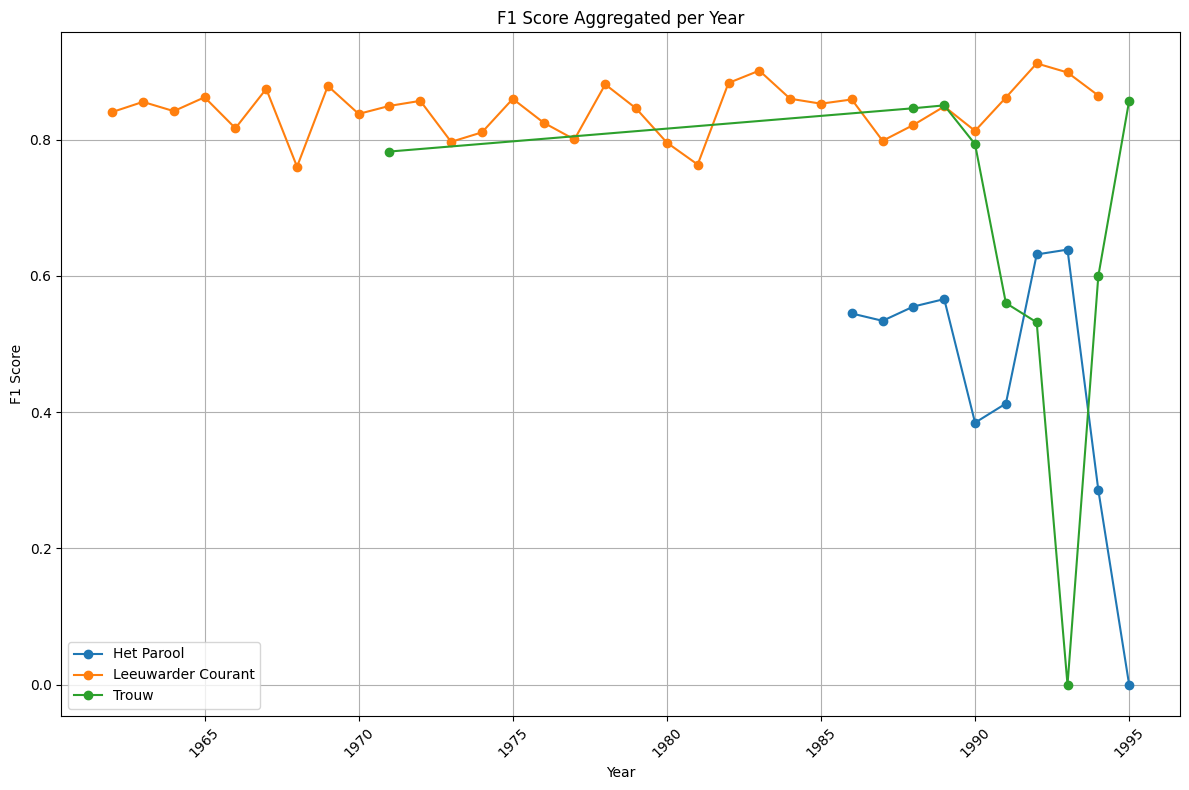

In [42]:
# Plotting the results
plt.figure(figsize=(12, 8))
for key, grp in df_results_merged.groupby(['dataset']):
    plt.plot(grp['year'], grp['f1'], marker='o', label=key[0])
plt.title('F1 Score Aggregated per Year')
plt.xlabel('Year')
plt.ylabel('F1 Score')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

In [43]:
df_results_merged.to_csv("f1_over_time.csv")

In [55]:
# Evaluate the model on the leeuwarde courant validation dataset
trainer.evaluate(lc_tokenized_dataset_val)

{'eval_loss': 1.4985970258712769,
 'eval_total_count_O': 852830,
 'eval_total_count_I': 21219,
 'eval_f1': 0.8392776200586874,
 'eval_recall': 0.8498405643057301,
 'eval_precision': 0.8289740327065366,
 'eval_accuracy': 0.9922921941447219,
 'eval_runtime': 136.2582,
 'eval_samples_per_second': 13.797,
 'eval_steps_per_second': 0.866}

In [56]:
# Evaluate the model on the leeuwarde courant test dataset
trainer.evaluate(lc_tokenized_dataset_test)

{'eval_loss': 1.4192105531692505,
 'eval_total_count_O': 848723,
 'eval_total_count_I': 21100,
 'eval_f1': 0.8426169835720102,
 'eval_recall': 0.851631329267112,
 'eval_precision': 0.8337914691943128,
 'eval_accuracy': 0.9924444398458077,
 'eval_runtime': 136.6655,
 'eval_samples_per_second': 13.764,
 'eval_steps_per_second': 0.863}

In [33]:
# Evaluate the model on the Trouw/Parool test dataset
trainer.evaluate(eval_dataset=trouw_tokenized_dataset_test)

{'eval_loss': 6.518800258636475,
 'eval_total_count_O': 55496,
 'eval_total_count_I': 813,
 'eval_f1': 0.6034739454094293,
 'eval_recall': 0.5058236272878536,
 'eval_precision': 0.7478474784747847,
 'eval_accuracy': 0.9858104388286064,
 'eval_runtime': 8.6625,
 'eval_samples_per_second': 13.276,
 'eval_steps_per_second': 0.924}

In [34]:
# Evaluate the model on the Trouw/Parool test dataset
trainer.evaluate(eval_dataset=parool_tokenized_dataset_test)

{'eval_loss': 6.703363418579102,
 'eval_total_count_O': 92713,
 'eval_total_count_I': 1653,
 'eval_f1': 0.5417598049176997,
 'eval_recall': 0.40789473684210525,
 'eval_precision': 0.8064125831820932,
 'eval_accuracy': 0.9761036814106776,
 'eval_runtime': 13.9217,
 'eval_samples_per_second': 13.863,
 'eval_steps_per_second': 0.934}